<a href="https://colab.research.google.com/github/mjhoover1/Robust_MAML/blob/main/MAML_dragen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code is sourced from https://github.com/dragen1860/MAML-Pytorch/blob/master/meta.py

Needed to save the model to google drive:

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
model_save_name = 'maml_omni_model.pt'
PATH = F"/content/gdrive/MyDrive/{model_save_name}"

In [4]:
%%writefile omniglot.py

import  torch.utils.data as data
import  os
import  os.path
import  errno


class Omniglot(data.Dataset):
    urls = [
        'https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip',
        'https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip'
    ]
    raw_folder = 'raw'
    processed_folder = 'processed'
    training_file = 'training.pt'
    test_file = 'test.pt'

    '''
    The items are (filename,category). The index of all the categories can be found in self.idx_classes
    Args:
    - root: the directory where the dataset will be stored
    - transform: how to transform the input
    - target_transform: how to transform the target
    - download: need to download the dataset
    '''

    def __init__(self, root, transform=None, target_transform=None, download=False):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform

        if not self._check_exists():
            if download:
                self.download()
            else:
                raise RuntimeError('Dataset not found.' + ' You can use download=True to download it')

        self.all_items = find_classes(os.path.join(self.root, self.processed_folder))
        self.idx_classes = index_classes(self.all_items)

    def __getitem__(self, index):
        filename = self.all_items[index][0]
        img = str.join('/', [self.all_items[index][2], filename])

        target = self.idx_classes[self.all_items[index][1]]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.all_items)

    def _check_exists(self):
        return os.path.exists(os.path.join(self.root, self.processed_folder, "images_evaluation")) and \
               os.path.exists(os.path.join(self.root, self.processed_folder, "images_background"))

    def download(self):
        from six.moves import urllib
        import zipfile

        if self._check_exists():
            return

        # download files
        try:
            os.makedirs(os.path.join(self.root, self.raw_folder))
            os.makedirs(os.path.join(self.root, self.processed_folder))
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        for url in self.urls:
            print('== Downloading ' + url)
            data = urllib.request.urlopen(url)
            filename = url.rpartition('/')[2]
            file_path = os.path.join(self.root, self.raw_folder, filename)
            with open(file_path, 'wb') as f:
                f.write(data.read())
            file_processed = os.path.join(self.root, self.processed_folder)
            print("== Unzip from " + file_path + " to " + file_processed)
            zip_ref = zipfile.ZipFile(file_path, 'r')
            zip_ref.extractall(file_processed)
            zip_ref.close()
        print("Download finished.")


def find_classes(root_dir):
    retour = []
    for (root, dirs, files) in os.walk(root_dir):
        for f in files:
            if (f.endswith("png")):
                r = root.split('/')
                lr = len(r)
                retour.append((f, r[lr - 2] + "/" + r[lr - 1], root))
    print("== Found %d items " % len(retour))
    return retour


def index_classes(items):
    idx = {}
    for i in items:
        if i[1] not in idx:
            idx[i[1]] = len(idx)
    print("== Found %d classes" % len(idx))
    return idx

Writing omniglot.py


In [5]:
%%writefile omniglotNShot.py
from    omniglot import Omniglot
import  torchvision.transforms as transforms
from    PIL import Image
import  os.path
import  numpy as np


class OmniglotNShot:

    def __init__(self, root, batchsz, n_way, k_shot, k_query, imgsz):
        """
        Different from mnistNShot, the
        :param root:
        :param batchsz: task num
        :param n_way:
        :param k_shot:
        :param k_qry:
        :param imgsz:
        """

        self.resize = imgsz
        if not os.path.isfile(os.path.join(root, 'omniglot.npy')):
            # if root/data.npy does not exist, just download it
            self.x = Omniglot(root, download=True,
                              transform=transforms.Compose([lambda x: Image.open(x).convert('L'),
                                                            lambda x: x.resize((imgsz, imgsz)),
                                                            lambda x: np.reshape(x, (imgsz, imgsz, 1)),
                                                            lambda x: np.transpose(x, [2, 0, 1]),
                                                            lambda x: x/255.])
                              )

            temp = dict()  # {label:img1, img2..., 20 imgs, label2: img1, img2,... in total, 1623 label}
            for (img, label) in self.x:
                if label in temp.keys():
                    temp[label].append(img)
                else:
                    temp[label] = [img]

            self.x = []
            for label, imgs in temp.items():  # labels info deserted , each label contains 20imgs
                self.x.append(np.array(imgs))

            # as different class may have different number of imgs
            self.x = np.array(self.x).astype(np.float)  # [[20 imgs],..., 1623 classes in total]
            # each character contains 20 imgs
            print('data shape:', self.x.shape)  # [1623, 20, 84, 84, 1]
            temp = []  # Free memory
            # save all dataset into npy file.
            np.save(os.path.join(root, 'omniglot.npy'), self.x)
            print('write into omniglot.npy.')
        else:
            # if data.npy exists, just load it.
            self.x = np.load(os.path.join(root, 'omniglot.npy'))
            print('load from omniglot.npy.')

        # [1623, 20, 84, 84, 1]
        # TODO: can not shuffle here, we must keep training and test set distinct!
        self.x_train, self.x_test = self.x[:1200], self.x[1200:]

        # self.normalization()

        self.batchsz = batchsz
        self.n_cls = self.x.shape[0]  # 1623
        self.n_way = n_way  # n way
        self.k_shot = k_shot  # k shot
        self.k_query = k_query  # k query
        assert (k_shot + k_query) <=20

        # save pointer of current read batch in total cache
        self.indexes = {"train": 0, "test": 0}
        self.datasets = {"train": self.x_train, "test": self.x_test}  # original data cached
        print("DB: train", self.x_train.shape, "test", self.x_test.shape)

        self.datasets_cache = {"train": self.load_data_cache(self.datasets["train"]),  # current epoch data cached
                               "test": self.load_data_cache(self.datasets["test"])}

    def normalization(self):
        """
        Normalizes our data, to have a mean of 0 and sdt of 1
        """
        self.mean = np.mean(self.x_train)
        self.std = np.std(self.x_train)
        self.max = np.max(self.x_train)
        self.min = np.min(self.x_train)
        # print("before norm:", "mean", self.mean, "max", self.max, "min", self.min, "std", self.std)
        self.x_train = (self.x_train - self.mean) / self.std
        self.x_test = (self.x_test - self.mean) / self.std

        self.mean = np.mean(self.x_train)
        self.std = np.std(self.x_train)
        self.max = np.max(self.x_train)
        self.min = np.min(self.x_train)

    # print("after norm:", "mean", self.mean, "max", self.max, "min", self.min, "std", self.std)

    def load_data_cache(self, data_pack):
        """
        Collects several batches data for N-shot learning
        :param data_pack: [cls_num, 20, 84, 84, 1]
        :return: A list with [support_set_x, support_set_y, target_x, target_y] ready to be fed to our networks
        """
        #  take 5 way 1 shot as example: 5 * 1
        setsz = self.k_shot * self.n_way
        querysz = self.k_query * self.n_way
        data_cache = []

        # print('preload next 50 caches of batchsz of batch.')
        for sample in range(10):  # num of episodes

            x_spts, y_spts, x_qrys, y_qrys = [], [], [], []
            for i in range(self.batchsz):  # one batch means one set

                x_spt, y_spt, x_qry, y_qry = [], [], [], []
                selected_cls = np.random.choice(data_pack.shape[0], self.n_way, False)

                for j, cur_class in enumerate(selected_cls):

                    selected_img = np.random.choice(20, self.k_shot + self.k_query, False)

                    # meta-training and meta-test
                    x_spt.append(data_pack[cur_class][selected_img[:self.k_shot]])
                    x_qry.append(data_pack[cur_class][selected_img[self.k_shot:]])
                    y_spt.append([j for _ in range(self.k_shot)])
                    y_qry.append([j for _ in range(self.k_query)])

                # shuffle inside a batch
                perm = np.random.permutation(self.n_way * self.k_shot)
                x_spt = np.array(x_spt).reshape(self.n_way * self.k_shot, 1, self.resize, self.resize)[perm]
                y_spt = np.array(y_spt).reshape(self.n_way * self.k_shot)[perm]
                perm = np.random.permutation(self.n_way * self.k_query)
                x_qry = np.array(x_qry).reshape(self.n_way * self.k_query, 1, self.resize, self.resize)[perm]
                y_qry = np.array(y_qry).reshape(self.n_way * self.k_query)[perm]

                # append [sptsz, 1, 84, 84] => [b, setsz, 1, 84, 84]
                x_spts.append(x_spt)
                y_spts.append(y_spt)
                x_qrys.append(x_qry)
                y_qrys.append(y_qry)


            # [b, setsz, 1, 84, 84]
            x_spts = np.array(x_spts).astype(np.float32).reshape(self.batchsz, setsz, 1, self.resize, self.resize)
            y_spts = np.array(y_spts).astype(np.int).reshape(self.batchsz, setsz)
            # [b, qrysz, 1, 84, 84]
            x_qrys = np.array(x_qrys).astype(np.float32).reshape(self.batchsz, querysz, 1, self.resize, self.resize)
            y_qrys = np.array(y_qrys).astype(np.int).reshape(self.batchsz, querysz)

            data_cache.append([x_spts, y_spts, x_qrys, y_qrys])

        return data_cache

    def next(self, mode='train'):
        """
        Gets next batch from the dataset with name.
        :param mode: The name of the splitting (one of "train", "val", "test")
        :return:
        """
        # update cache if indexes is larger cached num
        if self.indexes[mode] >= len(self.datasets_cache[mode]):
            self.indexes[mode] = 0
            self.datasets_cache[mode] = self.load_data_cache(self.datasets[mode])

        next_batch = self.datasets_cache[mode][self.indexes[mode]]
        self.indexes[mode] += 1

        return next_batch





if __name__ == '__main__':

    import  time
    import  torch
    import  visdom

    # plt.ion()
    viz = visdom.Visdom(env='omniglot_view')

    db = OmniglotNShot('db/omniglot', batchsz=20, n_way=5, k_shot=5, k_query=15, imgsz=64)

    for i in range(1000):
        x_spt, y_spt, x_qry, y_qry = db.next('train')


        # [b, setsz, h, w, c] => [b, setsz, c, w, h] => [b, setsz, 3c, w, h]
        x_spt = torch.from_numpy(x_spt)
        x_qry = torch.from_numpy(x_qry)
        y_spt = torch.from_numpy(y_spt)
        y_qry = torch.from_numpy(y_qry)
        batchsz, setsz, c, h, w = x_spt.size()


        viz.images(x_spt[0], nrow=5, win='x_spt', opts=dict(title='x_spt'))
        viz.images(x_qry[0], nrow=15, win='x_qry', opts=dict(title='x_qry'))
        viz.text(str(y_spt[0]), win='y_spt', opts=dict(title='y_spt'))
        viz.text(str(y_qry[0]), win='y_qry', opts=dict(title='y_qry'))


        time.sleep(10)

Writing omniglotNShot.py


In [6]:
%%writefile learner.py

import  torch
from    torch import nn
from    torch.nn import functional as F
import  numpy as np



class Learner(nn.Module):
    """
    """

    def __init__(self, config, imgc, imgsz):
        """
        :param config: network config file, type:list of (string, list)
        :param imgc: 1 or 3
        :param imgsz:  28 or 84
        """
        super(Learner, self).__init__()


        self.config = config

        # this dict contains all tensors needed to be optimized
        self.vars = nn.ParameterList()
        # running_mean and running_var
        self.vars_bn = nn.ParameterList()

        for i, (name, param) in enumerate(self.config):
            if name is 'conv2d':
                # [ch_out, ch_in, kernelsz, kernelsz]
                w = nn.Parameter(torch.ones(*param[:4]))
                # gain=1 according to cbfin's implementation
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

            elif name is 'convt2d':
                # [ch_in, ch_out, kernelsz, kernelsz, stride, padding]
                w = nn.Parameter(torch.ones(*param[:4]))
                # gain=1 according to cbfin's implementation
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_in, ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[1])))

            elif name is 'linear':
                # [ch_out, ch_in]
                w = nn.Parameter(torch.ones(*param))
                # gain=1 according to cbfinn's implementation
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

            elif name is 'bn':
                # [ch_out]
                w = nn.Parameter(torch.ones(param[0]))
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

                # must set requires_grad=False
                running_mean = nn.Parameter(torch.zeros(param[0]), requires_grad=False)
                running_var = nn.Parameter(torch.ones(param[0]), requires_grad=False)
                self.vars_bn.extend([running_mean, running_var])


            elif name in ['tanh', 'relu', 'upsample', 'avg_pool2d', 'max_pool2d',
                          'flatten', 'reshape', 'leakyrelu', 'sigmoid']:
                continue
            else:
                raise NotImplementedError






    def extra_repr(self):
        info = ''

        for name, param in self.config:
            if name is 'conv2d':
                tmp = 'conv2d:(ch_in:%d, ch_out:%d, k:%dx%d, stride:%d, padding:%d)'\
                      %(param[1], param[0], param[2], param[3], param[4], param[5],)
                info += tmp + '\n'

            elif name is 'convt2d':
                tmp = 'convTranspose2d:(ch_in:%d, ch_out:%d, k:%dx%d, stride:%d, padding:%d)'\
                      %(param[0], param[1], param[2], param[3], param[4], param[5],)
                info += tmp + '\n'

            elif name is 'linear':
                tmp = 'linear:(in:%d, out:%d)'%(param[1], param[0])
                info += tmp + '\n'

            elif name is 'leakyrelu':
                tmp = 'leakyrelu:(slope:%f)'%(param[0])
                info += tmp + '\n'


            elif name is 'avg_pool2d':
                tmp = 'avg_pool2d:(k:%d, stride:%d, padding:%d)'%(param[0], param[1], param[2])
                info += tmp + '\n'
            elif name is 'max_pool2d':
                tmp = 'max_pool2d:(k:%d, stride:%d, padding:%d)'%(param[0], param[1], param[2])
                info += tmp + '\n'
            elif name in ['flatten', 'tanh', 'relu', 'upsample', 'reshape', 'sigmoid', 'use_logits', 'bn']:
                tmp = name + ':' + str(tuple(param))
                info += tmp + '\n'
            else:
                raise NotImplementedError

        return info



    def forward(self, x, vars=None, bn_training=True):
        """
        This function can be called by finetunning, however, in finetunning, we dont wish to update
        running_mean/running_var. Thought weights/bias of bn is updated, it has been separated by fast_weights.
        Indeed, to not update running_mean/running_var, we need set update_bn_statistics=False
        but weight/bias will be updated and not dirty initial theta parameters via fast_weiths.
        :param x: [b, 1, 28, 28]
        :param vars:
        :param bn_training: set False to not update
        :return: x, loss, likelihood, kld
        """

        if vars is None:
            vars = self.vars

        idx = 0
        bn_idx = 0

        for name, param in self.config:
            if name is 'conv2d':
                w, b = vars[idx], vars[idx + 1]
                # remember to keep synchrozied of forward_encoder and forward_decoder!
                x = F.conv2d(x, w, b, stride=param[4], padding=param[5])
                idx += 2
                # print(name, param, '\tout:', x.shape)
            elif name is 'convt2d':
                w, b = vars[idx], vars[idx + 1]
                # remember to keep synchrozied of forward_encoder and forward_decoder!
                x = F.conv_transpose2d(x, w, b, stride=param[4], padding=param[5])
                idx += 2
                # print(name, param, '\tout:', x.shape)
            elif name is 'linear':
                w, b = vars[idx], vars[idx + 1]
                x = F.linear(x, w, b)
                idx += 2
                # print('forward:', idx, x.norm().item())
            elif name is 'bn':
                w, b = vars[idx], vars[idx + 1]
                running_mean, running_var = self.vars_bn[bn_idx], self.vars_bn[bn_idx+1]
                x = F.batch_norm(x, running_mean, running_var, weight=w, bias=b, training=bn_training)
                idx += 2
                bn_idx += 2

            elif name is 'flatten':
                # print(x.shape)
                x = x.view(x.size(0), -1)
            elif name is 'reshape':
                # [b, 8] => [b, 2, 2, 2]
                x = x.view(x.size(0), *param)
            elif name is 'relu':
                x = F.relu(x, inplace=param[0])
            elif name is 'leakyrelu':
                x = F.leaky_relu(x, negative_slope=param[0], inplace=param[1])
            elif name is 'tanh':
                x = F.tanh(x)
            elif name is 'sigmoid':
                x = torch.sigmoid(x)
            elif name is 'upsample':
                x = F.upsample_nearest(x, scale_factor=param[0])
            elif name is 'max_pool2d':
                x = F.max_pool2d(x, param[0], param[1], param[2])
            elif name is 'avg_pool2d':
                x = F.avg_pool2d(x, param[0], param[1], param[2])

            else:
                raise NotImplementedError

        # make sure variable is used properly
        assert idx == len(vars)
        assert bn_idx == len(self.vars_bn)


        return x


    def zero_grad(self, vars=None):
        """
        :param vars:
        :return:
        """
        with torch.no_grad():
            if vars is None:
                for p in self.vars:
                    if p.grad is not None:
                        p.grad.zero_()
            else:
                for p in vars:
                    if p.grad is not None:
                        p.grad.zero_()

    def parameters(self):
        """
        override this function since initial parameters will return with a generator.
        :return:
        """
        return self.vars


Writing learner.py


In [7]:
%%writefile meta.py

import  torch
from    torch import nn
from    torch import optim
from    torch.nn import functional as F
from    torch.utils.data import TensorDataset, DataLoader
from    torch import optim
import  numpy as np

from    learner import Learner
from    copy import deepcopy



class Meta(nn.Module):
    """
    Meta Learner
    """
    def __init__(self, args, config):
        """
        :param args:
        """
        super(Meta, self).__init__()

        self.update_lr = args.update_lr
        self.meta_lr = args.meta_lr
        self.n_way = args.n_way
        self.k_spt = args.k_spt
        self.k_qry = args.k_qry
        self.task_num = args.task_num
        self.update_step = args.update_step
        self.update_step_test = args.update_step_test


        self.net = Learner(config, args.imgc, args.imgsz)
        self.meta_optim = optim.Adam(self.net.parameters(), lr=self.meta_lr)




    def clip_grad_by_norm_(self, grad, max_norm):
        """
        in-place gradient clipping.
        :param grad: list of gradients
        :param max_norm: maximum norm allowable
        :return:
        """

        total_norm = 0
        counter = 0
        for g in grad:
            param_norm = g.data.norm(2)
            total_norm += param_norm.item() ** 2
            counter += 1
        total_norm = total_norm ** (1. / 2)

        clip_coef = max_norm / (total_norm + 1e-6)
        if clip_coef < 1:
            for g in grad:
                g.data.mul_(clip_coef)

        return total_norm/counter


    def forward(self, x_spt, y_spt, x_qry, y_qry):
        """
        :param x_spt:   [b, setsz, c_, h, w]
        :param y_spt:   [b, setsz]
        :param x_qry:   [b, querysz, c_, h, w]
        :param y_qry:   [b, querysz]
        :return:
        """
        task_num, setsz, c_, h, w = x_spt.size()
        querysz = x_qry.size(1)

        losses_q = [0 for _ in range(self.update_step + 1)]  # losses_q[i] is the loss on step i
        corrects = [0 for _ in range(self.update_step + 1)]


        for i in range(task_num):

            # 1. run the i-th task and compute loss for k=0
            logits = self.net(x_spt[i], vars=None, bn_training=True)
            loss = F.cross_entropy(logits, y_spt[i])
            grad = torch.autograd.grad(loss, self.net.parameters())
            fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, self.net.parameters())))

            # this is the loss and accuracy before first update
            with torch.no_grad():
                # [setsz, nway]
                logits_q = self.net(x_qry[i], self.net.parameters(), bn_training=True)
                loss_q = F.cross_entropy(logits_q, y_qry[i])
                losses_q[0] += loss_q

                pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                correct = torch.eq(pred_q, y_qry[i]).sum().item()
                corrects[0] = corrects[0] + correct

            # this is the loss and accuracy after the first update
            with torch.no_grad():
                # [setsz, nway]
                logits_q = self.net(x_qry[i], fast_weights, bn_training=True)
                loss_q = F.cross_entropy(logits_q, y_qry[i])
                losses_q[1] += loss_q
                # [setsz]
                pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                correct = torch.eq(pred_q, y_qry[i]).sum().item()
                corrects[1] = corrects[1] + correct

            for k in range(1, self.update_step):
                # 1. run the i-th task and compute loss for k=1~K-1
                logits = self.net(x_spt[i], fast_weights, bn_training=True)
                loss = F.cross_entropy(logits, y_spt[i])
                # 2. compute grad on theta_pi
                grad = torch.autograd.grad(loss, fast_weights)
                # 3. theta_pi = theta_pi - train_lr * grad
                fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, fast_weights)))

                logits_q = self.net(x_qry[i], fast_weights, bn_training=True)
                # loss_q will be overwritten and just keep the loss_q on last update step.
                loss_q = F.cross_entropy(logits_q, y_qry[i])
                losses_q[k + 1] += loss_q

                with torch.no_grad():
                    pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                    correct = torch.eq(pred_q, y_qry[i]).sum().item()  # convert to numpy
                    corrects[k + 1] = corrects[k + 1] + correct



        # end of all tasks
        # sum over all losses on query set across all tasks
        loss_q = losses_q[-1] / task_num

        # optimize theta parameters
        self.meta_optim.zero_grad()
        loss_q.backward()
        # print('meta update')
        # for p in self.net.parameters()[:5]:
        # 	print(torch.norm(p).item())
        self.meta_optim.step()


        accs = np.array(corrects) / (querysz * task_num)

        return accs


    def finetunning(self, x_spt, y_spt, x_qry, y_qry):
        """
        :param x_spt:   [setsz, c_, h, w]
        :param y_spt:   [setsz]
        :param x_qry:   [querysz, c_, h, w]
        :param y_qry:   [querysz]
        :return:
        """
        assert len(x_spt.shape) == 4

        querysz = x_qry.size(0)

        corrects = [0 for _ in range(self.update_step_test + 1)]

        # in order to not ruin the state of running_mean/variance and bn_weight/bias
        # we finetunning on the copied model instead of self.net
        net = deepcopy(self.net)

        # 1. run the i-th task and compute loss for k=0
        logits = net(x_spt)
        loss = F.cross_entropy(logits, y_spt)
        grad = torch.autograd.grad(loss, net.parameters())
        fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, net.parameters())))

        # this is the loss and accuracy before first update
        with torch.no_grad():
            # [setsz, nway]
            logits_q = net(x_qry, net.parameters(), bn_training=True)
            # [setsz]
            pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
            # scalar
            correct = torch.eq(pred_q, y_qry).sum().item()
            corrects[0] = corrects[0] + correct

        # this is the loss and accuracy after the first update
        with torch.no_grad():
            # [setsz, nway]
            logits_q = net(x_qry, fast_weights, bn_training=True)
            # [setsz]
            pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
            # scalar
            correct = torch.eq(pred_q, y_qry).sum().item()
            corrects[1] = corrects[1] + correct

        for k in range(1, self.update_step_test):
            # 1. run the i-th task and compute loss for k=1~K-1
            logits = net(x_spt, fast_weights, bn_training=True)
            loss = F.cross_entropy(logits, y_spt)
            # 2. compute grad on theta_pi
            grad = torch.autograd.grad(loss, fast_weights)
            # 3. theta_pi = theta_pi - train_lr * grad
            fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, fast_weights)))

            logits_q = net(x_qry, fast_weights, bn_training=True)
            # loss_q will be overwritten and just keep the loss_q on last update step.
            loss_q = F.cross_entropy(logits_q, y_qry)

            with torch.no_grad():
                pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                correct = torch.eq(pred_q, y_qry).sum().item()  # convert to numpy
                corrects[k + 1] = corrects[k + 1] + correct


        del net

        accs = np.array(corrects) / querysz

        return accs




def main():
    pass


if __name__ == '__main__':
    main()

Writing meta.py


In [8]:
%%writefile omniglot_train.py

import  torch, os
import  numpy as np
from    omniglotNShot import OmniglotNShot
import  argparse
import pathlib
from pathlib import Path
from tqdm import tqdm

from    meta import Meta

def main(args):

    torch.manual_seed(222)
    torch.cuda.manual_seed_all(222)
    np.random.seed(222)

    print(args)

    config = [
        ('conv2d', [64, 1, 3, 3, 2, 0]),
        ('relu', [True]),
        ('bn', [64]),
        ('conv2d', [64, 64, 3, 3, 2, 0]),
        ('relu', [True]),
        ('bn', [64]),
        ('conv2d', [64, 64, 3, 3, 2, 0]),
        ('relu', [True]),
        ('bn', [64]),
        ('conv2d', [64, 64, 2, 2, 1, 0]),
        ('relu', [True]),
        ('bn', [64]),
        ('flatten', []),
        ('linear', [args.n_way, 64])
    ]

    device = torch.device('cuda')
    maml = Meta(args, config).to(device)
    start = 0

    path = Path(args.checkpoint_path)
    if path.is_file():
      loaded_checkpoint = torch.load(args.checkpoint_path)
      # if exists then use checkpoint model and change the epoch to the checkpoint epoch
      start = loaded_checkpoint['epoch']
      maml.load_state_dict(loaded_checkpoint['model_state_dict']) # load params into model
      maml.meta_optim.load_state_dict(loaded_checkpoint['optimizer_state_dict']) # load checkpoint optimizer
      # loss = checkpoint['loss']
      # You must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference
      # Failing to do this will yield inconsistent inference results. If you wish to resume training call model.train() to ensure these layers are in training mode

    tmp = filter(lambda x: x.requires_grad, maml.parameters())
    num = sum(map(lambda x: np.prod(x.shape), tmp))
    print(maml)
    print('Total trainable tensors:', num)

    db_train = OmniglotNShot('omniglot',
                       batchsz=args.task_num,
                       n_way=args.n_way,
                       k_shot=args.k_spt,
                       k_query=args.k_qry,
                       imgsz=args.imgsz)

    for step in tqdm(range(start, args.epoch)):

        x_spt, y_spt, x_qry, y_qry = db_train.next()
        x_spt, y_spt, x_qry, y_qry = torch.from_numpy(x_spt).to(device), torch.from_numpy(y_spt).to(device), \
                                     torch.from_numpy(x_qry).to(device), torch.from_numpy(y_qry).to(device)

        # set traning=True to update running_mean, running_variance, bn_weights, bn_bias
        accs = maml(x_spt, y_spt, x_qry, y_qry)

        if step % 50 == 0:
            print('step:', step, '\ttraining acc:', accs)
            checkpoint = {
                "epoch": step,
                "model_state_dict": maml.state_dict(),
                "optimizer_state_dict": maml.meta_optim.state_dict()
            }
            torch.save(checkpoint, PATH)

        if step % 500 == 0:
            accs = []
            for _ in range(1000//args.task_num):
                # test
                x_spt, y_spt, x_qry, y_qry = db_train.next('test')
                x_spt, y_spt, x_qry, y_qry = torch.from_numpy(x_spt).to(device), torch.from_numpy(y_spt).to(device), \
                                             torch.from_numpy(x_qry).to(device), torch.from_numpy(y_qry).to(device)

                # split to single task each time
                for x_spt_one, y_spt_one, x_qry_one, y_qry_one in zip(x_spt, y_spt, x_qry, y_qry):
                    test_acc = maml.finetunning(x_spt_one, y_spt_one, x_qry_one, y_qry_one)
                    accs.append( test_acc )

            # [b, update_step+1]
            accs = np.array(accs).mean(axis=0).astype(np.float16)
            print('Test acc:', accs)


if __name__ == '__main__':
    # Uncomment for debugging use only
    # breakpoint()
    model_save_name = 'maml_omni_model.pt'
    PATH = F"/content/gdrive/MyDrive/{model_save_name}"

    argparser = argparse.ArgumentParser()
    argparser.add_argument('--epoch', type=int, help='epoch number', default=40000)
    argparser.add_argument('--n_way', type=int, help='n way', default=5)
    argparser.add_argument('--k_spt', type=int, help='k shot for support set', default=1)
    argparser.add_argument('--k_qry', type=int, help='k shot for query set', default=15)
    argparser.add_argument('--imgsz', type=int, help='imgsz', default=28)
    argparser.add_argument('--imgc', type=int, help='imgc', default=1)
    argparser.add_argument('--task_num', type=int, help='meta batch size, namely task num', default=32)
    argparser.add_argument('--meta_lr', type=float, help='meta-level outer learning rate', default=1e-3)
    argparser.add_argument('--update_lr', type=float, help='task-level inner update learning rate', default=0.4)
    argparser.add_argument('--update_step', type=int, help='task-level inner update steps', default=5)
    argparser.add_argument('--update_step_test', type=int, help='update steps for finetunning', default=10)
    argparser.add_argument('--checkpoint_path', type=pathlib.Path, help='Path for checkpoint model to train', default=PATH)

    args = argparser.parse_args()

    main(args)

Writing omniglot_train.py


In [9]:
# To load checkpoint first initialize the model and the optimizer, then load the dictionary locally.

In [ ]:
!python omniglot_train.py

Namespace(checkpoint_path=PosixPath('/content/gdrive/MyDrive/maml_omni_model.pt'), epoch=40000, imgc=1, imgsz=28, k_qry=15, k_spt=1, meta_lr=0.001, n_way=5, task_num=32, update_lr=0.4, update_step=5, update_step_test=10)
Meta(
  (net): Learner(
    conv2d:(ch_in:1, ch_out:64, k:3x3, stride:2, padding:0)
    relu:(True,)
    bn:(64,)
    conv2d:(ch_in:64, ch_out:64, k:3x3, stride:2, padding:0)
    relu:(True,)
    bn:(64,)
    conv2d:(ch_in:64, ch_out:64, k:3x3, stride:2, padding:0)
    relu:(True,)
    bn:(64,)
    conv2d:(ch_in:64, ch_out:64, k:2x2, stride:1, padding:0)
    relu:(True,)
    bn:(64,)
    flatten:()
    linear:(in:64, out:5)
    
    (vars): ParameterList(
        (0): Parameter containing: [torch.cuda.FloatTensor of size 64x1x3x3 (GPU 0)]
        (1): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
        (2): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0)]
        (3): Parameter containing: [torch.cuda.FloatTensor of size 64 (GPU 0

Few-shot learning means making classification or regression based on a very small number of samples. 

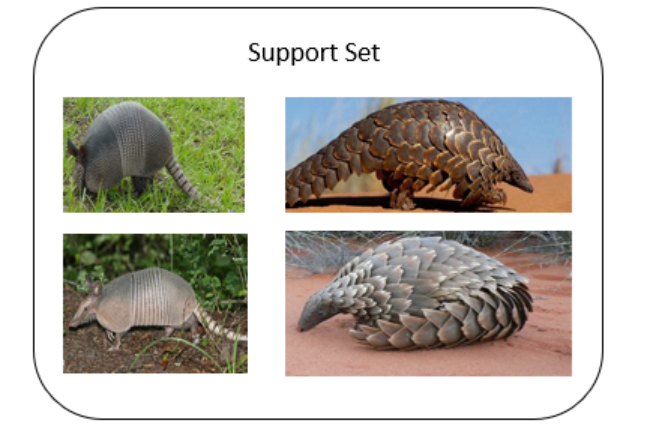



The left 2 imgs are Armadillos and the right 2 imgs are pangolins. Now, suppose this query:

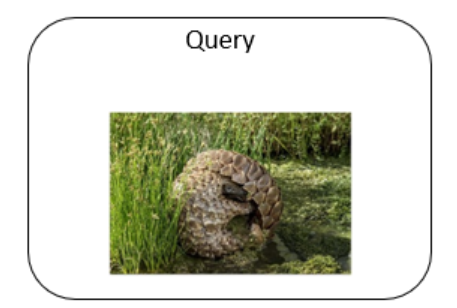

Do you think it is a Armadillo or Pangolin? Humans can learn to distinguish the two animals using merely 4 training samples.

# Few-shot learning

**Few-shot learning** is the problem of making predictions based on a limited number of samples. The goal of few-shot learning is not to let the model recognize the images in the training set and then generalize to the test. Instead, the goal is to learn.

Think of Learn to learn this way 
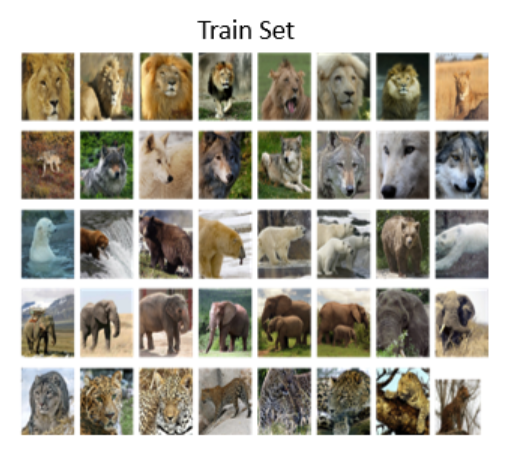

I train the model on a big training set. The goal of training is not to know what an elephant is and what a tiger is. Insteadt, the goal is to know the similarity and difference between objects.
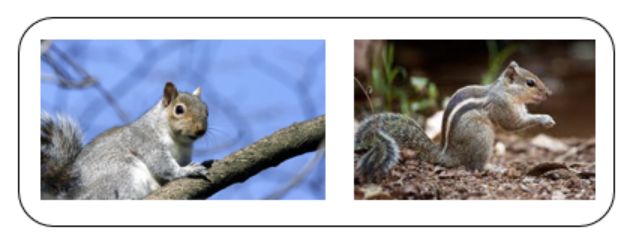

After, training you can show the two images to the model and ask whether the 2 are the same kind of animals. The model has similarities and differences between objects. So, the model is able to tell that the contents in the two imgs are the same kind of objects.

The training data has 5 classes that don't include the squirrel class. Thus, the model is unable to recognize squirrels. When the model sees the 2 imgs, it doesn't know they are squirrels. However, the model knows they look alike. The model can tell you with high confidence that they are the same kind of objects.

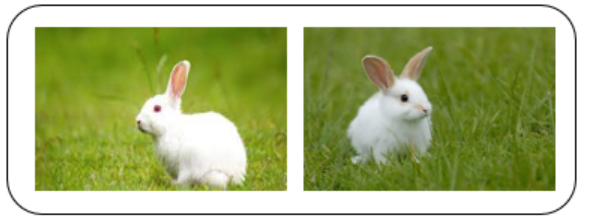

Similarly, the model has never senn a rabbit during training, so it doesn't know the imgs are rabbits. The model knows that the contents of the two imgs are very similar, and can tell the difference between objects it's never seen as well.

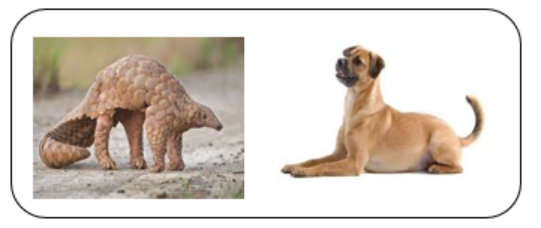

# Support set vs Training set

The small set of labeled imgs is called a support set. 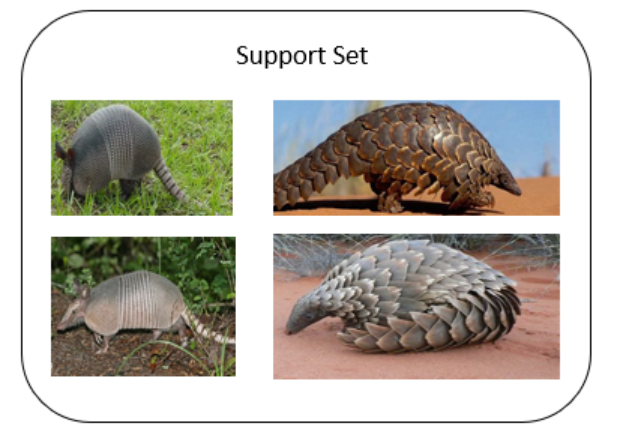

Note the differences between the training set and the support set. The training set is big enough for learning a deep neural network. But, the support set is small. Every class has at most a few samples. The support set can only provide additional info at test time. 

The basic idea of few-shot learning is we don't train a big model using a big training set. Rather training the model to recognize specific objects such as tigers and elephants in the training set, we train the model to know the similarity and differences b/t objects.

# Meta-learning

Few-shot learning is a kind of meta-learning. Meta-learning is different from traditional supervised learning. Traditional supervised learning asks the model to recognize the training data and then to generalize to unseen test data. But, meta-learning's goal is to learn. 

## How to understand learn to learn?

A kid is at the zoo and sees an animal (otter) he's never seen before and asks his dad what's this? The dad gives the kid a set of cards. On them, there is an animal and its name. He has never seen the animals on the cards one of them is an otter. The kid finds the animal is an otter because the one on the card is most similar to the animal at the zoo. Teaching the kid to learn by himself is called **meta-learning**.

Before going to the zoo, the kid could already learn by himself. He knew the similarity and differences b/t the animals. In meta-learning, the unknown animal is called a **query**. You give him a card and let him learn by himself, the set of cards is the **support set**. Learning to learn by himself is called meta-learning. If there is only one card for every specie, this is **one-shot learning**.

# Few-shot learning vs Supervised learning

Traditional supervised learning is to train a model using a big training set. After the model is trained, the model can be used for making predictions. When the model is shown a test sample it recognizes it. Few-shot learning is different it's given a query sample of objects/classes its never seen before. 

# Terminologies in few-shot learning

**k-way** means the support set has k classes.

**n-shot** means every class has n samples.

The support set is called **k-way and n-shot**.

# Prediction accuracy of few-shot learning 

When performing few-shot learning, the prediction accuracy depends on the number of ways and the number of shots. As the number of ways increases, the prediction accuracy drops, but why? For example, the kid is given 3 cards and asked to choose 1/3. This is 3-way 1-shot learning, but what if the kid was given 6 cards? This would be 6-way 1-shot learning. 

Obviously, 3-way is easier than 6-way, because choosing 1/3 is easier than choosing 1/6.

As the number of shots increases, the prediction accuracy improves. Since there are more samples, the prediction becomes easier. Thus, 2-shot is easier than 1-shot.

# Basic idea behind few-shot learning

The basic idea of few-shot learning is to train a function that predicts similarity. Denote the similarity function by $sim(x,x')$, which measures the similarity b/t two samples, x and x'.

If the two samples are the same, the similarity function returns 1, i.e., $sim(x,x')=1$. If the samples are different, they return 0, i.e., $sim(x,x')=0$. After training, the learned similarity function can be used for making predictions for unseen queries. We can use the similarity function to compare the query with every sample in the support set and calculate the similarity scores. Then, find the sample with the highest similarity score and use it as the prediction. For example:

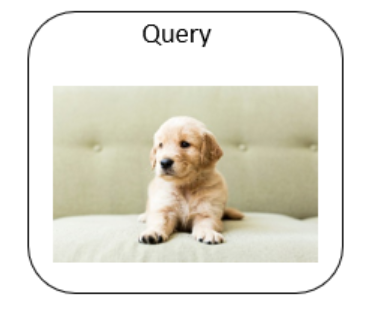

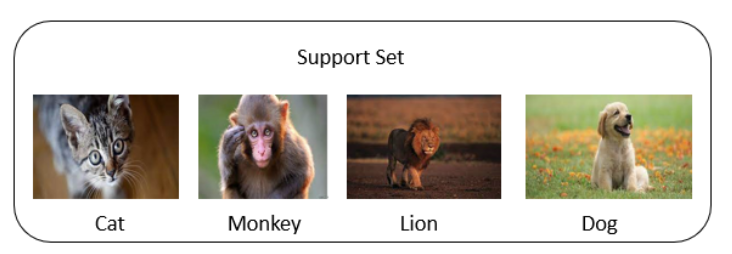

Given the query img, I want to know what the img is. We can compare the query with every sample in the support set:$$sim(cat, dog)=.6\\sim(monkey,dog)=.4\\sim(lion,dog)=.2\\sim(dog,dog)=.9$$ 

Among the scores .9 is the biggest. Thus, the model predicts the query is a dog. One-shot learning can be performed in this way.

# Datasets for few-shot learning

Omniglot is the most frequently used dataset. It is a hand-written dataset. 

Another commonly used dataset is Mini-ImageNet.

# Tasks

New tasks can be anything from regression, classification, and even reinforcement learning. 

A Task ($T$) is defined as $T=\{S,Q\}$, where $S$ is the support set - the specific amount of labeled data and $Q$ - specific amount of data that can be labeled or not depending if your in the testing stage.
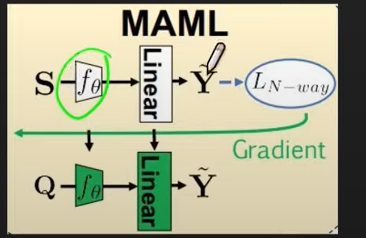

**Input:** Given a training dataset $D_{meta-train}$ that contains $n$ sub-datasets, each for $i^{th}$ task (episode) $T_i$:
$$D_{meta-train} = {T_i}^n_{i=1}$$
$$T_i = \{(D^{train}_i, D^{test}_i)\} = \text{Episode}\space i$$
\begin{cases} 
      D_{i}^{train}=\{(x_{j}^{i},y_{j}^{i})\}_{j=1}^K \\
      D_{i}^{test}=\{(x_{j}^{i}, y_{j}^{i})\}_{j=1}^{K'} \\ 
\end{cases}

supervised meta-learning: $f(D_{train}, x) \rightarrow y$, where $D_{train}$ is the training set. 
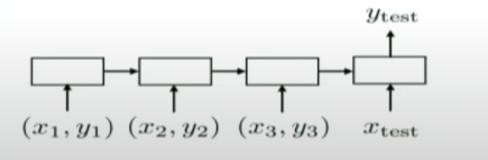

## Finetuning

Finetuning is when you train using a large source domain training set, then you fine tune by training a little bit on your target domain. 

# Model-Agnostic Meta-Learning

The challenges with conventional machine learning algorithms:
1. Intensive training is required
2. Labeled data for some problems may be limited.
3. The performance of the network may be sensitive to the choice of hyperparameters. 

In such respect, meta-learning algorithms can be designed to address the follwing tasks:
1. Dynamic selection of inductive bias
2. Building meta-rules for multi-task learning
3. Learning to learn with hyperparameter optimization

## Intuition

- MAML doesn't learn an update function or learning rule, it learns the model parameters in a fully differentiable way.
- Agnostic, in the sense that the method can be used in different contexts, few-shot learning is a particular case.
- It has a probablistic interpretation in terms of hierarchical models (more on this in the next episodes).

# High-level overview of algorithm

NN is parameterized by our weights $\theta$, we want to find a set of weights $\theta$ so they can easily adapt to new solutions in very few gradient steps. Suppose were in a 5-way 1-shot setting: $S=\{(x_1,y_1),\cdots,(x_5,y_5)\}$, $Q=\{(x_1,Y_1)\}$, so this is our task $T$. Suppose we have three of these tasks with 5 different support sets and queries.

We consider $T_1$ and our model is parameterized by $f_\theta$ with params $\theta$, so well pass the support set $S_1$: $f_\theta(S_1)=y_1$. Now, we'll fine tune the parameters $\theta$ towards a specific set of parameters $\theta_1$ through one step of gradient descent:
$$\theta_1 = \theta - \alpha \nabla_0 L(S_1,y_1)$$
We now obtained a specific configuration of weights $\theta_1^*$. Now, we'll do another forward pass using parameters $\theta_1$ on the query set $Q_1$: $f_{\theta_1}(Q_1)=Y_1$, where $Y_1$ is the prediction on the query set. Now, we'll do another backward pass, but this time on $\theta$ using the query set: $$\theta = \theta - \beta \nabla_\theta L(Q_1, Y_1)$$
We want to optimize $\theta$ because we want to do well on this query set. To conclude this chain of operations you need to take the gradient of the gradient. We take the average of these gradients on each of the query set which gives us good parameters $\theta$.


## Overview of algorithm

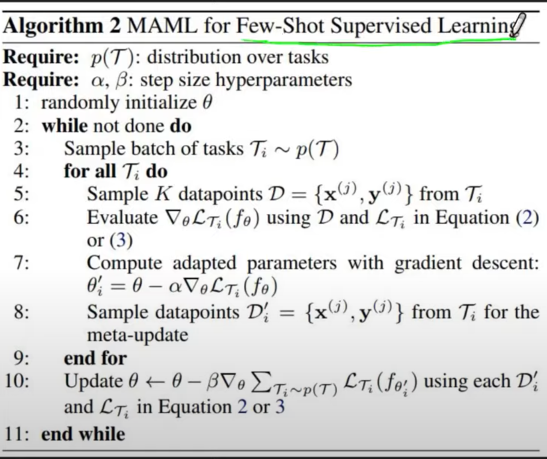

We have a distribution over tasks $p(T)$ meaning we can sample a specific task $T_i\approx p(T)$. We have our two step hyperparameters $\alpha, \beta$. We have an outer loop and an inner loop, and in the outer loop we'll update $\theta$. While in the inner loop $\theta_i'$ which are the task specific parameters. 

Focusing on the inner loop: 
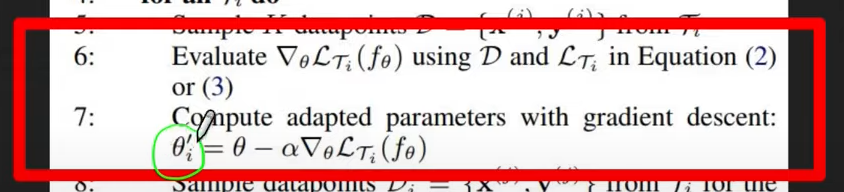

We'll evaluate the loss on the task specific data, and were going to estimate the parameters on these specific tasks moving weights in specific direction of the gradient. This is done on the support set, even though there is no inner loop we could have a loop and do multiple gradient steps. $\theta \rightarrow \theta_1' \rightarrow \theta_1''$. This is problematic because the computational graph will get very large. 

In the outer loop:
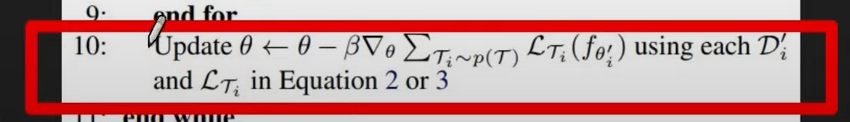

In the outer loop, we will update $\theta$ through another gradient step done on the query set. 

## Algorithm in code

1. Sample some batch of tasks $T_i \approx p(T)$
2. Iterate over all the tasks we just sampled in the for loop. We can get the train inputs, train_targets from the support set. Also, we can get the test_inputs, test_targets from the query set. 
3. Then, we will pass the train inputs to the model computing the forward pass of the model. This will give us some predictions our train logits = $y_i$. 
4. We have the first inner loss on the support set using cross entropy on the train logits and train target. 
5. We now have to compute the adaptive parameters with gradient descent which can be done as torch.autograd.grad(inner_loss, model.meta_params(), create_graph=True). We'll keep the graph so we have it later for the outer loop and define dictionary of params = OrderedDict(). Below we iterate over the model parameters and take the gradients updating $\theta$
```
for(name, param), grad in zip(model.meta_named_pars(), grads):
      params[name] = param - step_size * grad
```
6. Now, we will sample meta-points or query points but this was already done. Now, be careful were doing this over multiple task so we have to do a sum over all the losses over all the tasks. Once, going out of the inner loop the outer loss will contain all the possible losses over all the tasks. Once, computing the backward pass it will do the backward pass over all tasks specific losses.
```
outer_loss += F.cross_entropy(test_logit, test_target) # on query set
```
7. Once, the backward pass is done for the query set:

```
outer_loss.backward()
``` 
then well apply the optimizer: 
```
meta_opt.step()
``` 

## Learning to initialize

Algorithms in this class aim to choose a set of parameters that can be fine-tuned very easily to another task via one or more gradient learning steps. This criterion encourages the network to learn a stable feature set that is applicable to many different domains, with a set of parameters on top of these that can be easily modified to exploit this representation.

**MAML** is a model and task-agnostic algorithm for meta-learning that trains a model's parameters such that a small number of gradient updates will lead to fast learning on a new task. MAML is a meta-learning framework that can be applied to any model that is trained with a gradient descent procedure. The aim is to learn a general model that can easily be fine-tuned for many different tasks, even when the training data is scarce. 

Consider a model represented by a parameterized function $f_\theta$ with parameters $\theta$. When adapting to a new task $T_i$, the model's parameters $\theta$ become $\theta_i'$. With MAML the updated parameter vector $\theta_i'$ is computed using one or more gradient descent updates on task $T_i$. For examples, when using one gradient update, 
$$\theta_i'=\theta-\alpha \nabla_\theta L_{T_i}(f_\theta)$$ 
to create a task-specific set of parameters $\theta_i'$. Here, the network is denoted by $f$ with parameters $\theta$. The loss $L(\cdot, \cdot)$ takes the model $f$ and the task data $T_i$ as parameters. The step size $\alpha$ may be fixed as a hyperparameter or metalearned. The model parameters are trained by optimizing for the performance of $f_{\theta_i'}$ with respect to $\theta$ across tasks sampled from $p(T_i)$. More concretely the meta-objective is as follows: 
$$\min_\theta{\sum_{T_i \approx p(T)}L_{T_i}(f_{\theta_i'})=\sum_{T_i \approx p(T)}L_{T_i}(f_{\theta-\alpha \nabla_\theta L_{T_i}(f_\theta)})}$$


Note that the meta-optimization is performed over the model parameters $\theta$, whereas the objective is computed using the updated model parameters $\theta'$. In effect MAML aims to optimize the model parameters such that one or a small number of gradient steps on a new task will produce maximally effective behavior on that task. The meta-optimization across tasks is performed via stochastic gradient descent (SGD), such that the model parameters $\theta$ are updated as follows:
$$\theta \leftarrow \theta - \beta \nabla_\theta \sum_{T_i \approx p(T)}{L_{T_i}(f_{\theta_i'})} (Eqn\space 3)$$
where $\beta$ is the meta step size. 

The goal is that on average for a number of different tasks, the loss will be small with these parameters. The meta-cost function $M[\cdot]$ encompasses this idea:
$$M_\theta=\sum_{j=1}^J{L[f_{\theta_i},T_i]}$$
where each set of parameters $\theta_i$ is itself a function of $\theta$. We wish to minimize this cost, which we can do by taking gradient descent steps in (3). This would typically be done in a stochastic fashion, updating the meta-cost function with respect to a few tasks at a time. In this way, MAML gradually learns parameters $\theta$ which can be adapted to many tasks by fine tuning. 

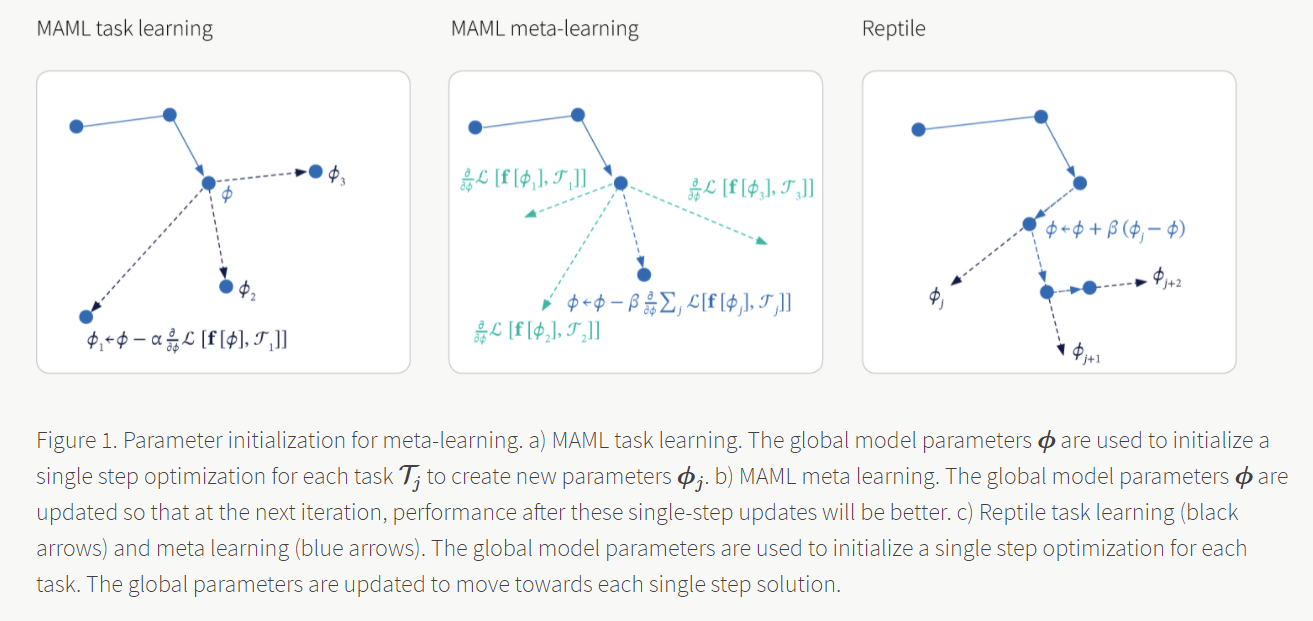

## First order MAML

MAML has the disadvantage that both the meta-learning objective (equation 3) and the task learning objective within it (equation 1) contain gradients, and so we have to take gradients of gradients (via a Hessian matrix) to perform each update. 

To improve the efficiency of learning first order model agnostic meta learning or FOMAML which simply omitted the second derivatives. Suprisingly, this did not impact performance. They speculate that this might be because the RELU networks are almost linear and so the second derivatives are close to zero.

## Reptile

Nichol et al. (2018) introduced a simpler variant of first order MAML which they called Reptile. As for MAML, the algorithm repeatedly samples task $T_i$, and optimizes the global parameters $\theta$ to create task specific parameters $\theta_i$. Then it updates the global parameters using the rule: 
$$\theta \leftarrow \theta + \alpha(\theta_i - \theta)$$


This is illustrated in figure 1c. One interpretation of this is that we are performing stochastic gradient descent on a task level rather than a data level.

Jayathilaka (2019) improved this method by adding two thresholds $\beta$ and $\gamma$ as hyper-parameters. After $\beta$ steps, the gradient is pruned so that if the change in parameters $(\theta_i - \theta) < \gamma$ then no change is made. The logic of this approach is that the end of the meta-training procedure is over-learning the training tasks and hence this part of the regime is damped. 

## What kind of problems MAML solves?

MAML is designed such that it trains a model on a variety of tasks such that it can learn a new learning task with only a small number of training samples. 

A few important points of MAML are:
1. MAML doesn't expand the number of learned parameters.
2. No constraint on the architecture or network of the model. 

## Problem Setup

Problem setup for MAML is reproduced from 

In [ ]:
%cd MAML-Pytorch/

/content/MAML-Pytorch


In [ ]:
%ls

backup/     meta.py                omniglotNShot.py   README.md
learner.py  MiniImagenet.py        omniglot.py        res/
LICENSE     miniimagenet_train.py  omniglot_train.py  test.py
